# Standalone Flow Matching

Ported from Facebook Research's [standalone_flow_matching.ipynb](https://github.com/facebookresearch/flow_matching/blob/main/examples/standalone_flow_matching.ipynb).

In [1]:
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import numpy as np

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

In [45]:
class Flow(nnx.Module):
  def __init__(self, dim: int = 2, h: int = 64, *, rngs: nnx.Rngs):
    self.net = nnx.Sequential(
      nnx.Linear(dim + 1, h, rngs=rngs), nnx.elu,
      nnx.Linear(h, h, rngs=rngs), nnx.elu,
      nnx.Linear(h, h, rngs=rngs), nnx.elu,
      nnx.Linear(h, dim, rngs=rngs),
    )

  def __call__(self, t: jax.Array, x_t: jax.Array) -> jax.Array:
    return self.net(jnp.concatenate((t, x_t), axis=-1))

  def step(self, x_t: jax.Array, t_start: jax.Array, t_end: jax.Array) -> jax.Array:
    t_start = jnp.full(x_t.shape[0], t_start)[..., None]

    return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t=x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)


nnx.display(Flow(rngs=nnx.Rngs(0)))

# Training

In [47]:
rngs = nnx.Rngs(0)
flow = Flow(rngs=rngs)
optimizer = nnx.Optimizer(flow, tx=optax.adam(1e-2))
mse = lambda a, b: jnp.mean((a - b) ** 2)


@nnx.jit
def train_step(flow, optimizer, rngs, x_1):
  x_0 = jax.random.normal(rngs(), x_1.shape)
  t = jax.random.uniform(rngs(), (len(x_1), 1))

  x_t = (1 - t) * x_0 + t * x_1
  dx_t = x_1 - x_0

  grads = nnx.grad(lambda flow: mse(flow(t, x_t), dx_t))(flow)
  optimizer.update(grads)

for _ in range(10_000):
  x_1 = make_moons(256, noise=0.05)[0]
  train_step(flow, optimizer, rngs, x_1)

# Sampling

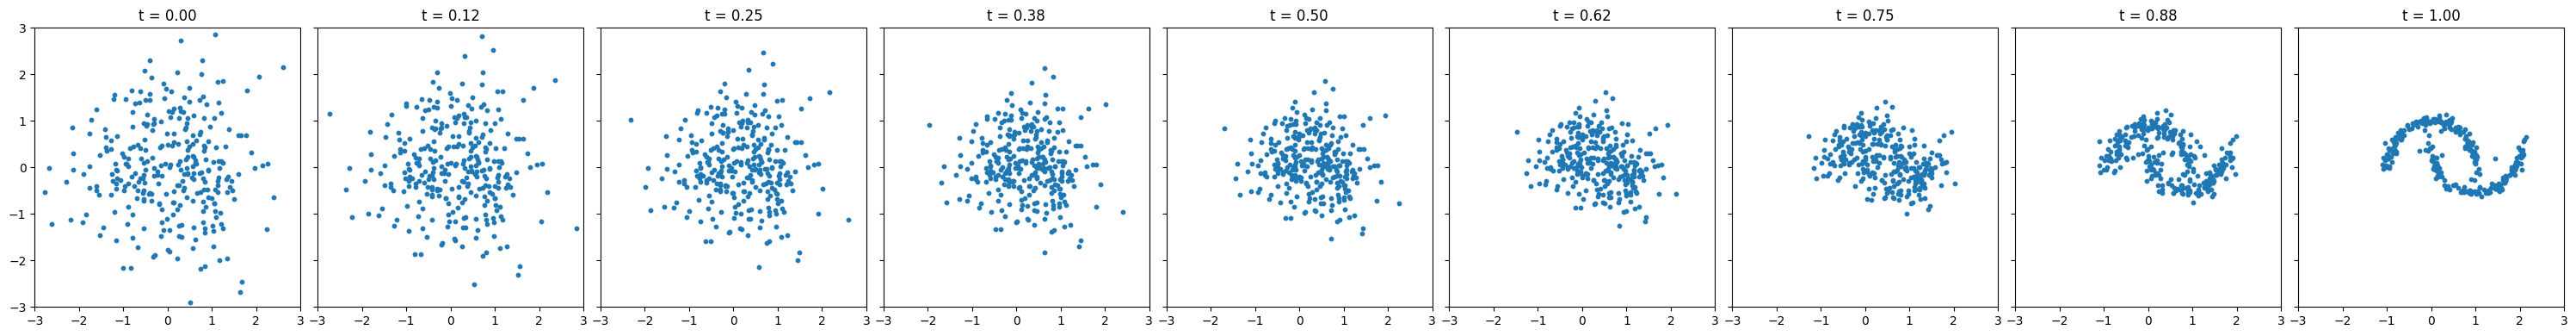

In [51]:
x = np.random.randn(300, 2)
n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = np.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x[:, 0], x[:, 1], s=10)
axes[0].set_title(f"t = {time_steps[0]:.2f}")
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
  x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
  axes[i + 1].scatter(x[:, 0], x[:, 1], s=10)
  axes[i + 1].set_title(f"t = {time_steps[i + 1]:.2f}")

plt.tight_layout()
plt.show()